In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal
from pathlib import Path
from dem_stitcher.rio_window import read_raster_from_window

# Generate Tiles

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(14)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(14)]
# data
df_peckel_data = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Sample url: https://storage.googleapis.com/global-surface-water/downloads2020/occurrence/occurrence_70W_20Sv1_3_2020.tif

<AxesSubplot:>

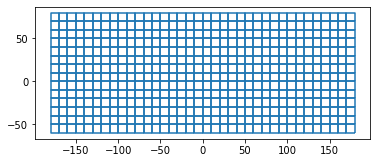

In [7]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/global-surface-water/downloads2020/occurrence'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):d}W'
    else:
        lon_str = f'{abs(lon):d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):d}N'
    else:
        lat_str = f'{abs(lat):d}S'
    return f'{base_url}/occurrence_{lon_str}_{lat_str}v1_3_2020.tif'

df_peckel_data['source_url'] = list(map(url_generator, ul_corners))
df_peckel_data['year'] = 2020
df_peckel_data.boundary.plot()

In [8]:
sample_url = df_peckel_data.source_url[0]
print(sample_url)

https://storage.googleapis.com/global-surface-water/downloads2020/occurrence/occurrence_180W_80Nv1_3_2020.tif


In [9]:
df_peckel_data.to_file('peckel_tiles.geojson', driver='GeoJSON')

In [6]:
with rasterio.open(sample_url) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -180.0,
       0.0, -0.00025, 80.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

# Get Peckel Data

In [11]:
def build_peckel_vrt(extent: list, 
                     out_path: Path):
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

In [8]:
df_chips = gpd.read_file('chips.geojson')
df_chips.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [9]:
chip_id = 42
bounds_4326 = df_chips[df_chips.random_id == chip_id].total_bounds
bounds_4326

array([-95.97375,  32.94   , -95.76   ,  33.12   ])

In [12]:
X_occ, p_occ = get_peckel_raster(list(bounds_4326))

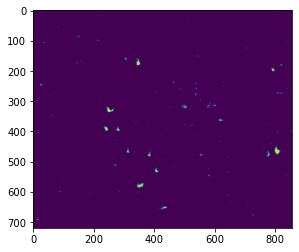

In [13]:
plt.imshow(X_occ)

In [14]:
with rasterio.open(f'peckel_occurence_c{chip_id}.tif', 'w', **p_occ) as ds:
    ds.write(X_occ, 1)